In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys, os 
sys.path.append("../../")

from data_loading import load_runs, load_runs_detvar

In [3]:
from microfit import detsys
from microfit.histogram import Binning, MultiChannelBinning, Histogram, MultiChannelHistogram

In [4]:
binning_def = ("reco_e", 10, (0.15, 1.55), r"Reconstructed Energy [GeV]")  # reproduce technote

binning_npl = Binning.from_config(*binning_def)
binning_npl.set_selection(preselection="NP", selection="NPBDT")
binning_npl.label = "NPBDT"

binning_zpl = Binning.from_config(*binning_def)
binning_zpl.set_selection(preselection="ZP", selection="ZPBDT")
binning_zpl.label = "ZPBDT"

signal_binning = MultiChannelBinning([binning_npl, binning_zpl])

In [5]:
detsys_data = detsys.make_variations(
    ["3"],
    "bnb",
    signal_binning,
    variations=["cv", "lydown","lyatt","recomb2"],
    truth_filtered_sets=["nue","nc_pi0"],
    # Choose which additional variables to load. Which ones are required may depend on the selection
    # you wish to apply.
    loadpi0variables=True,
    loadshowervariables=True,
    loadrecoveryvars=True,
    loadsystematics=True,
    load_crt_vars=False,
    # Load the nu_e set one more time with the LEE weights applied
    load_lee=False,
    # With the cache enabled, by default the loaded dataframes will be stored as HDF5 files
    # in the 'cached_dataframes' folder. This will speed up subsequent loading of the same data.
    enable_cache=True,
)

In [6]:
detsys_data.keys()

dict_keys(['run', 'binning', 'variation_hist_data', 'mc_sets', 'extra_selection_query'])

In [7]:
import numpy as np
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF

def rolling_filter_smooth_bin_counts(arr):
    """Filter the array with the given filter, reflecting the array at the edges.
    
    This method returns no standard deviations.
    """
    # Make another figure demonstrating the effect of smoothing the summed variations
    filter = np.array([0.1, 0.3, 1.0, 0.3, 0.1])
    filter /= np.sum(filter)
    # pad the array with zeros
    arr_padded = np.pad(arr, (len(filter) // 2, len(filter) // 2), mode="edge")
    # apply the filter
    arr_filtered = np.convolve(arr_padded, filter, mode="valid")
    return arr_filtered, None

def gp_smooth_bin_counts(arr, std_devs, bin_centers=None, scale_factor=0.1):
    """Filter bin counts using a Gaussian process, using the standard deviations as the noise levels.
    
    The kernel is a RBF kernel with a length scale that is relative to the entire range of the binning.
    """
    if bin_centers is not None:
        x = bin_centers
    else:
        x = np.arange(len(arr))
    # rescale x to be between 0 and 1
    x_min = np.min(x)
    x_max = np.max(x)
    x = (x - x_min) / (x_max - x_min)
    x = x.reshape(-1, 1)
    mean_y = np.mean(arr)
    y = arr - mean_y
    y = y.reshape(-1, 1)
    kernel = RBF(length_scale=scale_factor)
    gp = GaussianProcessRegressor(kernel=kernel, alpha=std_devs ** 2)
    gp.fit(x, y)
    y_pred, sigma = gp.predict(x, return_std=True)
    return np.squeeze(y_pred) + mean_y, sigma

def smooth_bin_counts(hist, method="rolling", **kwargs):
    """Smooth the bin counts using the given filter.
    
    The method parameter can be "rolling" or "gp".
    """
    bin_counts = hist.bin_counts
    std_devs = hist.std_devs
    bin_centers = hist.bin_centers
    if method == "rolling":
        return rolling_filter_smooth_bin_counts(bin_counts)
    elif method == "gp":
        return gp_smooth_bin_counts(bin_counts, std_devs, bin_centers=bin_centers, **kwargs)
    else:
        raise ValueError(f"Unknown method: {method}")


def filter_hist(hist, method="rolling", **kwargs):
    if isinstance(hist, MultiChannelHistogram):
        # We have to apply the filter separately for each channel
        return MultiChannelHistogram.from_histograms(
            [filter_hist(h, method=method) for h in  hist]
        )
    else:
        smoothed_counts, std = smooth_bin_counts(hist, method=method, **kwargs)
        hist.bin_counts = smoothed_counts
        if std is not None:
            hist.covariance_matrix = np.diag(std ** 2)
    return hist

In [8]:
summed_variations = {}
for truth_filter, hist_dict in detsys_data["variation_hist_data"].items():
    for name, hist in hist_dict.items():
        if name not in summed_variations:
            summed_variations[name] = hist
        else:
            summed_variations[name] += hist

detsys_data["summed_variations"] = summed_variations

In [9]:
detsys_data["summed_variations"].keys()

dict_keys(['cv', 'lydown', 'lyatt', 'recomb2'])

In [10]:
channel = "ZPBDT"
variation = "recomb2"
hist = detsys_data["summed_variations"][variation][channel].copy()

../../microfit/histogram/binning.py:265: UserWarning: The 'labels' property is deprecated. Use 'channels' instead.
  "The 'labels' property is deprecated. Use 'channels' instead.",


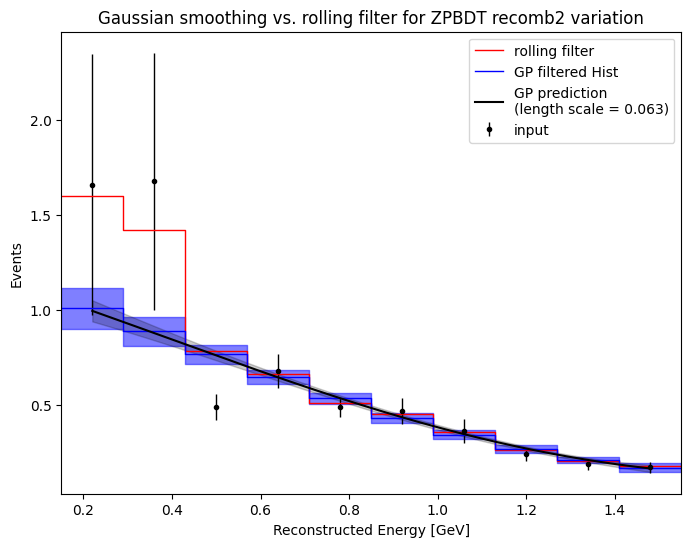

In [11]:
import matplotlib.pyplot as plt



gp_scale_factor = 0.05

fig, ax = plt.subplots(1, 1, figsize=(8, 6))

hist.draw(ax=ax, color="k", lw=1, label="input", as_errorbars=True)
filter_hist(hist).draw(ax=ax, color="r", lw=1, label="rolling filter", show_errors=False)
filter_hist(hist, method="gp", scale_factor=gp_scale_factor).draw(ax=ax, color="b", lw=1, label="GP filtered Hist", show_errors=True)

# Plot the input into the Gaussian Process and the predicted line]
x = hist.bin_centers
y = hist.bin_counts
yerr = hist.std_devs
# rescale x
x_min = np.min(x)
x_max = np.max(x)
x = (x - x_min) / (x_max - x_min)
# Remove the mean from the data
mean_y = np.mean(y)
y = y - mean_y
x = x.reshape(-1, 1)
y = y.reshape(-1, 1)

kernel = RBF(length_scale=gp_scale_factor)
gp = GaussianProcessRegressor(kernel=kernel, alpha=yerr ** 2)
gp.fit(x, y)

# plot smoothed points with error bars
# y_pred, sigma = gp.predict(x, return_std=True)
# y_pred = np.squeeze(y_pred) + mean_y
# ax.errorbar(np.squeeze(x), y_pred, yerr=yerr, fmt="o", color="g", label="GP smoothed points")

# plot the GP prediction
x_plot = np.linspace(np.min(x), np.max(x), 1000)
y_pred, sigma = gp.predict(x_plot.reshape(-1, 1), return_std=True)
y_pred = np.squeeze(y_pred) + mean_y
# scale x_plot back 
x_plot = x_plot * (x_max - x_min) + x_min
ax.plot(x_plot, y_pred, "k-", label=f"GP prediction\n(length scale = {gp_scale_factor * (x_max - x_min)})")
ax.fill_between(x_plot, y_pred - sigma, y_pred + sigma,  alpha=0.2, color="k")

ax.set_title(f"Gaussian smoothing vs. rolling filter for {channel} {variation} variation")
ax.legend()